# Descriptive analysis of civilians-shot data

Simply summarizes the data, sliced in myriad ways

### PRO TIP: Just skim for the graphs if you are only interested in the results

Author: Everett Wetchler (everett.wetchler@gmail.com)

## Setup and read data

In [1]:
DTW_PROJECT_KEY = 'tji/auxiliary-datasets'
OIS_FILENAME = '../data-processing/data/clean/shot_civilians.csv'
SAVE_PLOTS = True
PLOT_DIR= 'plots/'
PLOT_PREFIX = 'OIS_Civilians_'

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

import datetime as dt
import os
import random

import datadotworld as dw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Personal libraries
import evutils.everett_eda as eda

## Jupyter setup
%matplotlib inline

## Graphical setup
# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
SNS_COLORS = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
pd.set_option('display.max_columns', 500)
plt.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Watermark extension to print version/system information
# Flags:
# -a [author] -d (date) -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version) -p [packages] (package info)
%load_ext watermark
%watermark -a "Everett Wetchler" -d -t -z -w -p numpy,pandas,matplotlib,datadotworld

####################################################
# END Boilerplate
####################################################

Everett Wetchler 2018-05-01 16:23:53 CDT

numpy 1.14.3
pandas 0.20.1
matplotlib 2.2.0
datadotworld 1.6.0
watermark 1.5.0


In [3]:
from wordcloud import WordCloud

In [4]:
# Helper function to (optionally) save and name plots)
plotcount = 0
def saveplot(fig, name):
    if SAVE_PLOTS:
        global plotcount
        plotcount += 1
        filename = os.path.join(PLOT_DIR, PLOT_PREFIX + "%02d_%s.png" % (plotcount, name))
        fig.savefig(filename)

In [5]:
shootings = pd.read_csv(OIS_FILENAME)

for c in shootings.columns:
    if c.startswith('date'):
        shootings[c] = pd.to_datetime(shootings[c])

print("Civilians shot data from %s to %s" % (
    shootings.date_incident.min().strftime('%Y-%m-%d'),
    shootings.date_incident.max().strftime('%Y-%m-%d')))

Civilians shot data from 2015-09-02 to 2018-04-16


## WHEN do shootings happen?

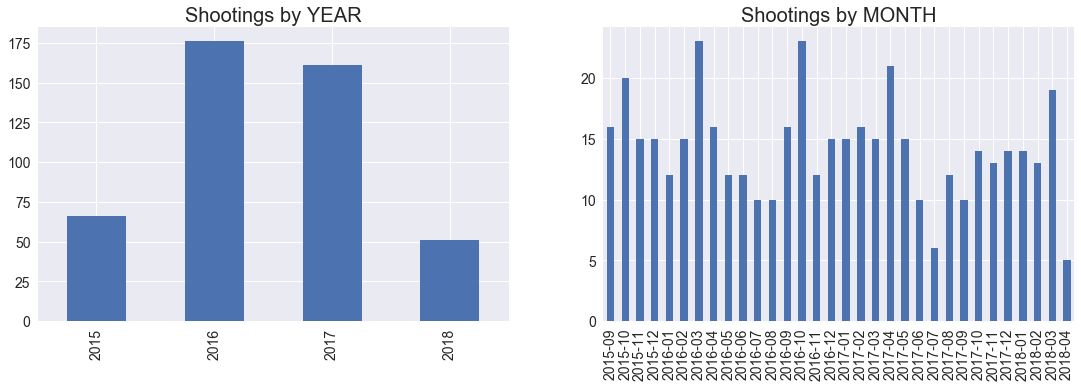

In [6]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 6)
axes[0].set_title('Shootings by YEAR')
shootings['date_incident'].apply(lambda dt: '%d' % (dt.year)).value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[1].set_title('Shootings by MONTH')
shootings['date_incident'].apply(lambda dt: '%d-%02d' % (dt.year, dt.month)).value_counts().sort_index().plot(kind='bar', ax=axes[1])
plt.subplots_adjust(left=.05, right=.95, bottom=0.2)
saveplot(fig, 'year_month')

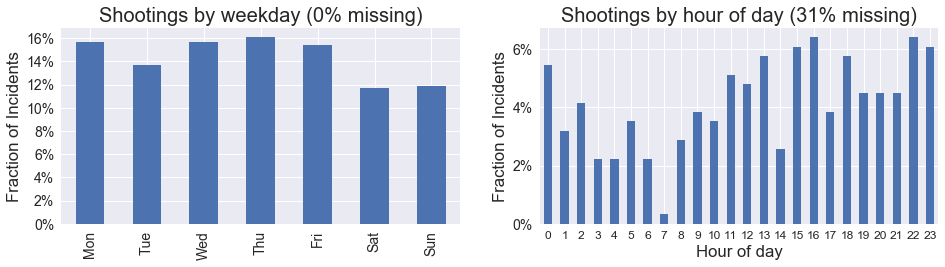

In [7]:
fig, axes = plt.subplots(1, 2)

ax = axes[0]
fig.set_size_inches(14, 4)
counts = shootings['date_incident'].apply(lambda dt: dt.weekday()).value_counts(True).sort_index()
ax.set_yticks(np.arange(0, 0.21, 0.02))
ax.set_ylabel('Fraction of Incidents')
eda.percentify_y(ax, decimals=0)
counts.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
counts.plot(kind='bar', ax=ax)
ax.set_title('Shootings by weekday (%.0f%% missing)' % (shootings.date_incident.isnull().mean() * 100))
plt.xticks(rotation=45)

ax = axes[1]
shootings['hour'] = shootings.time_incident.dropna().apply(lambda t: int(t.split(':')[0])).astype(int)
shootings.hour.value_counts(True).sort_index().plot(kind='bar', ax=ax)
ax.set_xlabel('Hour of day')
ax.set_ylabel('Fraction of Incidents')
eda.percentify_y(ax, decimals=0)
ax.set_title('Shootings by hour of day (%.0f%% missing)' % (shootings.time_incident.isnull().mean() * 100))
ax.set_xticklabels([int(t) for t in ax.get_xticks()], fontsize=12, rotation=0)


plt.subplots_adjust(left=.08, right=.95, bottom=0.2)
saveplot(fig, 'weekday_hour')

## WHERE do shootings happen?

In [8]:
datasets = dw.load_dataset(DTW_PROJECT_KEY, force_update=True)
county_seats = datasets.dataframes['texas_counties'].set_index('county')['seat']
county_seats.head()

county
ANDERSON      PALESTINE
ANDREWS         ANDREWS
ANGELINA         LUFKIN
ARANSAS        ROCKPORT
ARCHER      ARCHER CITY
Name: seat, dtype: object

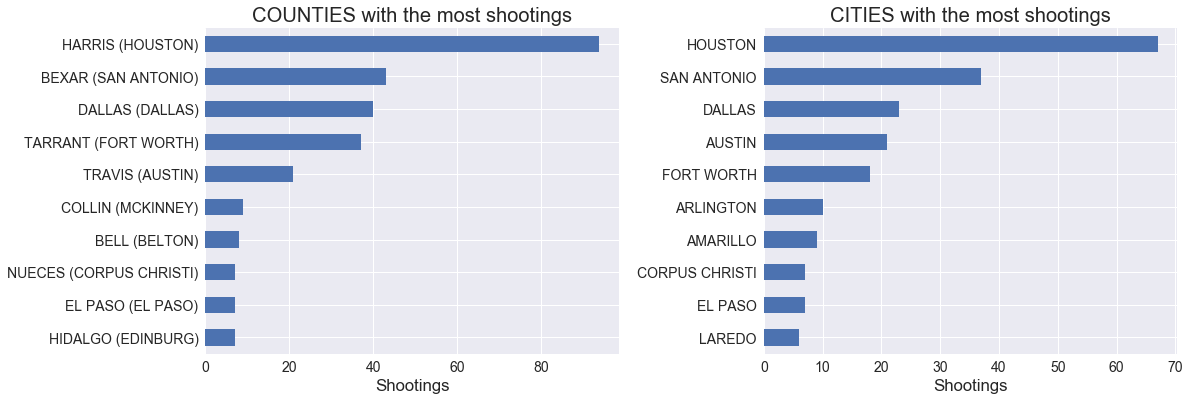

In [9]:
top_counties = shootings.incident_county.value_counts().head(10)
top_counties.index = pd.Series(top_counties.index).apply(
    lambda county: "%s (%s)" % (county, county_seats[county]))

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ax = axes[0]
top_counties[::-1].plot(kind='barh', ax=ax)
ax.set_title('COUNTIES with the most shootings')
ax.set_xlabel("Shootings")

ax = axes[1]
shootings['incident_city'].value_counts()[:10][::-1].plot(kind='barh', ax=ax)
ax.set_title("CITIES with the most shootings")
ax.set_xlabel("Shootings")

plt.subplots_adjust(left=0.2, wspace=.35, right=.95)
saveplot(fig, 'shootings_by_location')

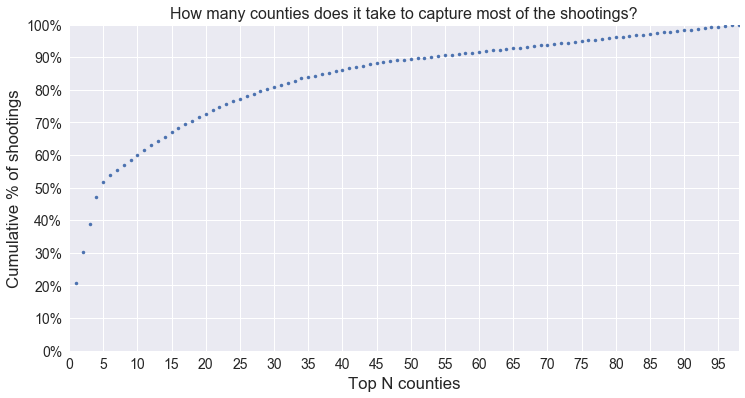

In [10]:
fig, ax = plt.subplots(1)
s = shootings['incident_county'].value_counts(True, ascending=False)
s.index = range(1, len(s) + 1)
s.cumsum().plot(ax=ax, marker='.', linewidth=0)
ax.set_ylim((0, 1))
ax.set_yticks(np.arange(0, 1.01, .1))
ax.set_yticklabels(['%d%%' % i for i in range(0, 101, 10)])
ax.set_xticks(range(0, 100, 5))
ax.legend_ = None
ax.set_title('How many counties does it take to capture most of the shootings?', fontsize=16)
ax.set_xlabel('Top N counties')
ax.set_ylabel('Cumulative % of shootings')
fig.set_size_inches(12, 6)
saveplot(fig, 'cumulative_shootings_by_county')

## What civilians get shot?

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


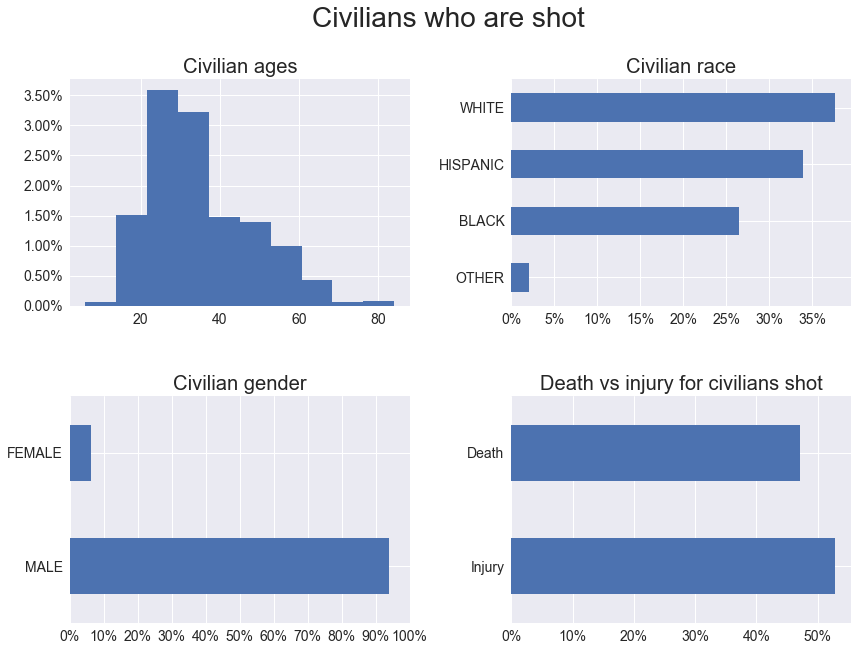

In [11]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(14, 10)
fig.suptitle('Civilians who are shot', fontsize=28)

ax = axes[0][0]
shootings.civilian_age.hist(ax=ax, normed=True)
ax.set_title('Civilian ages')
eda.percentify_y(ax)

ax = axes[0][1]
shootings.civilian_race.value_counts(True)[::-1].plot(kind='barh', ax=ax)
ax.set_title('Civilian race')
eda.percentify_x(ax, decimals=0)

ax = axes[1][0]
shootings.civilian_gender.value_counts(True).plot(kind='barh', ax=ax)
ax.set_xticks(np.arange(0, 1.01, .1))
ax.set_title('Civilian gender')
eda.percentify_x(ax)

ax = axes[1][1]
shootings[shootings['date_incident'].apply(lambda dt: dt.year) == 2016]['civilian_died'].value_counts(True).plot(kind='barh', ax=ax)
ax.set_yticklabels([ 'Death' if t.get_text() == 'True' else 'Injury' for t in ax.get_yticklabels()])
eda.percentify_x(ax)
ax.set_title('Death vs injury for civilians shot')

plt.subplots_adjust(hspace=0.4, wspace=.3)
saveplot(fig, 'civilian_summary')

## What officers are involved?

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


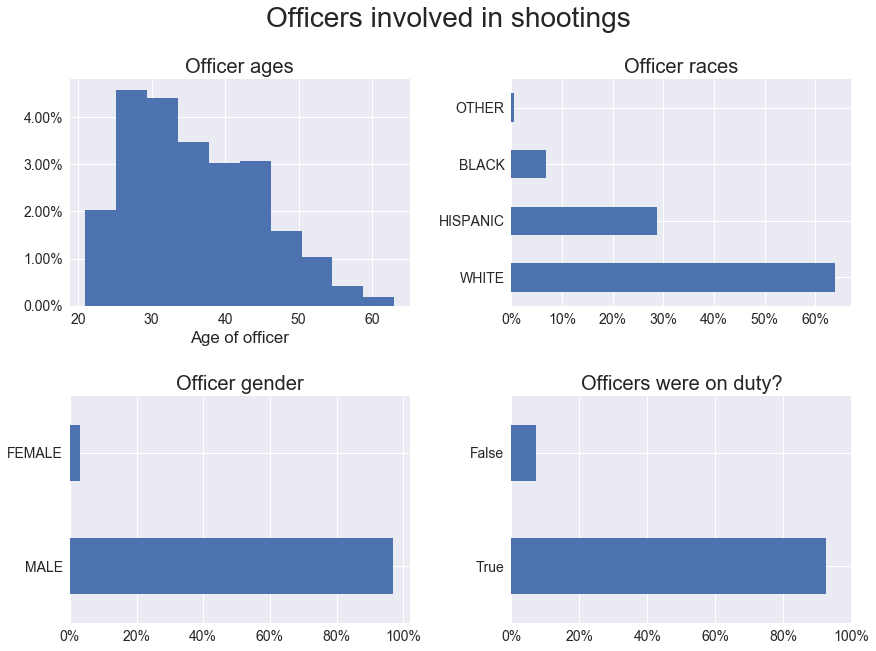

In [12]:
all_officer_ages = []
all_officer_races = []
all_officer_genders = []
for i in range(1, 11):
    all_officer_ages.extend(list(shootings['officer_age_%d' % i].dropna()))
    all_officer_races.extend(list(shootings['officer_race_%d' % i].dropna()))
    all_officer_genders.extend(list(shootings['officer_gender_%d' % i].dropna()))

all_officer_ages = pd.Series(all_officer_ages)
all_officer_races = pd.Series(all_officer_races)
all_officer_genders = pd.Series(all_officer_genders)
N_OFFICERS = shootings['num_officers_recorded'].sum()

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(14, 10)
fig.suptitle('Officers involved in shootings', fontsize=28)

ax = axes[0][0]
all_officer_ages.hist(ax=ax, normed=True)
ax.set_title('Officer ages')
ax.set_xlabel('Age of officer')
eda.percentify_y(ax)

ax = axes[0][1]
all_officer_races.value_counts(True).plot(kind='barh', ax=ax)
ax.set_title('Officer races')
eda.percentify_x(ax)

ax = axes[1][0]
all_officer_genders.value_counts(True).plot(kind='barh', ax=ax)
ax.set_title('Officer gender')
eda.percentify_x(ax)

ax = axes[1][1]
shootings.on_duty.value_counts(True).plot(kind='barh', ax=ax)
ax.set_title('Officers were on duty?')
ax.set_xlim((0, 1))
eda.percentify_x(ax)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
saveplot(fig, 'officer_summary')

## Miscellaneous

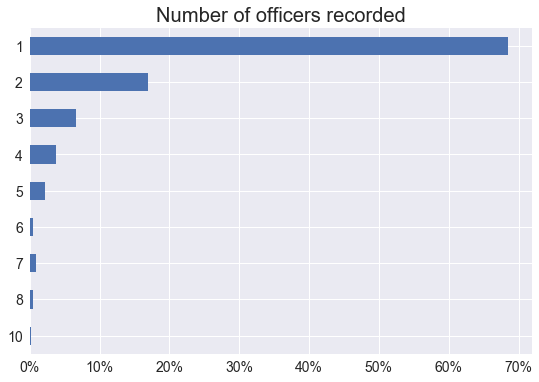

In [13]:
fig, ax = plt.subplots(1)
shootings.num_officers_recorded.value_counts(True).sort_index(ascending=False).plot(kind='barh', ax=ax)
ax.set_title('Number of officers recorded')
ax.set_xticks(np.arange(0, 0.71, 0.1))
eda.percentify_x(ax)

In [14]:
race_pairs = []
for i in range(1, 11):
    for civilian, officer in zip(shootings['civilian_race'], shootings['officer_race_%d' % i]):
        if pd.notnull(officer):
            race_pairs.append([civilian, officer])

tmp = pd.DataFrame(race_pairs, columns=['civilian', 'officer'])
tab = pd.crosstab(tmp['civilian'], tmp['officer'])
race_order = ['WHITE', 'BLACK', 'HISPANIC', 'OTHER']
tab.loc[race_order, race_order]

officer,WHITE,BLACK,HISPANIC,OTHER
civilian,,,,
WHITE,191,11,65,1
BLACK,149,26,42,2
HISPANIC,118,12,102,1
OTHER,14,1,4,0


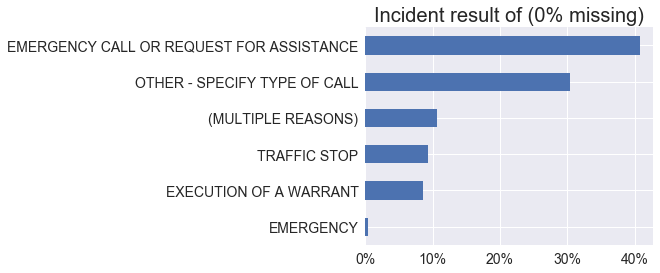

In [15]:
fig, ax = plt.subplots(1)
shootings.incident_result_of.apply(lambda res: '(MULTIPLE REASONS)' if ',' in res else res).value_counts(True)[::-1].plot(kind='barh', ax=ax)
fig.set_size_inches(10,4)
ax.set_title('Incident result of (%.0f%% missing)' % (shootings.incident_result_of.isnull().mean() * 100))
eda.percentify_x(ax, decimals=0)
plt.subplots_adjust(left=0.5)
saveplot(fig, 'incident_result_of')

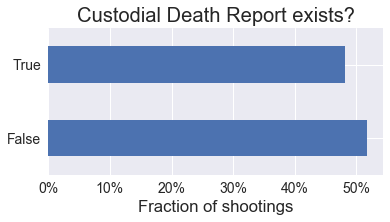

In [16]:
fig, ax = plt.subplots(1)
shootings.custodial_death_report.value_counts(True).plot(kind='barh', ax=ax)
ax.set_title('Custodial Death Report exists?')
ax.set_xlabel('Fraction of shootings')
fig.set_size_inches(6, 3)
eda.percentify_x(ax)
plt.subplots_adjust(bottom=0.2)
saveplot(fig, 'cdr_exists')

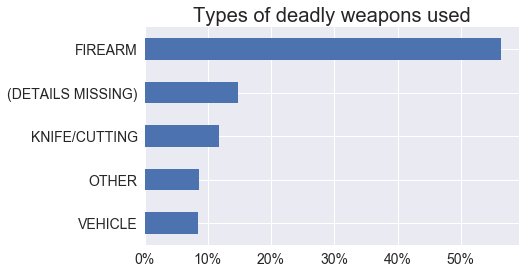

In [17]:
fig, ax = plt.subplots(1)
weapons = shootings.deadly_weapon_category[shootings.deadly_weapon_category != '(details missing)']
weapons.value_counts(True, ascending=True).plot(kind='barh', ax=ax)
ax.set_title('Types of deadly weapons used')
eda.percentify_x(ax)
fig.set_size_inches(8, 4)
plt.subplots_adjust(left=0.25)
saveplot(fig, 'deadly_weapon_types')

219 CDR narratives published, 45 LEA narratives published


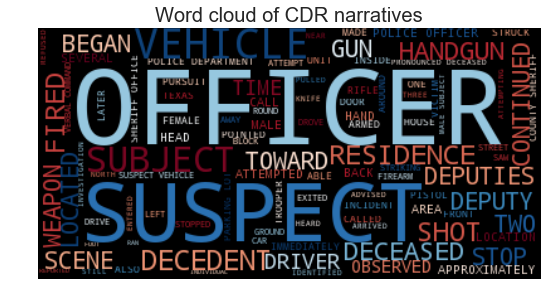

In [18]:
cdr = []
lea = []
for x in shootings['cdr_narrative'].values:
    if pd.notnull(x):
        cdr.append(x)
for x in shootings['lea_narrative_published'].values:
    if pd.notnull(x):
        lea.append(x)

print("%d CDR narratives published, %d LEA narratives published" % (len(cdr), len(lea)))

all_cdr = []
for x in cdr:
    all_cdr.extend(x.split())

remove_words = []#set(['suspect', 'officer', 'subject', 'police'])
text = []
for w in all_cdr:
    invalid = False
    for rem in remove_words:
        if rem in w.lower():
            invalid = True
            break
    if not invalid:
        text.append(w)
text = ' '.join(text)

cloud = WordCloud(background_color="black", max_words=100, colormap='RdBu').generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.gca().set_title('Word cloud of CDR narratives')
saveplot(plt.gcf(), 'cdr_narrative_wordcloud')